In [1]:
import json
import uproot
import matplotlib.pyplot as plt
import numpy as np
from coffea.analysis_objects import JaggedCandidateArray
from coffea import hist
import coffea.processor as processor
from uproot_methods import TVector3Array
from awkward import JaggedArray
from matplotlib.colors import LogNorm

from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline

In [26]:
dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

bkgdatasets_=json.load(open('../../MC/Samples/backgrounds_nonempty.json'))

In [3]:
testfile = dataset4mu_['mXX-100_mA-5_lxy-0p3'][0]
f = uproot.open(testfile)['ffNtuplizer/ffNtuple']

In [5]:
ljparts_pt = NestNestObjArrayToJagged(f['pfjet_pfcand_pt'].array())
ljparts_eta = NestNestObjArrayToJagged(f['pfjet_pfcand_eta'].array())
ljparts_phi = NestNestObjArrayToJagged(f['pfjet_pfcand_phi'].array())
ljparts_energy = NestNestObjArrayToJagged(f['pfjet_pfcand_energy'].array())

In [14]:
def transform(x, y, v):
    """
    linear transform scatter points to get a generally unified pattern,
    leading points at origin, subleading points on positie x axis, sorted by ``v``,
    the upper semiplane has larger energy sum.
    
    ``x``, ``y``, ``v`` are JaggedArray having the same shape, (x, y) are coordinates
    """

    coords = TVector3Array.from_cartesian(x, y, x.zeros_like())
    sortedidx = v.argsort()
    maxidx = JaggedArray.fromfolding(sortedidx[:, 0], 1)
    subidx = JaggedArray.fromfolding(sortedidx[:, 1], 1)
    
    ## translation, move leading points to origin
    coords_t = coords - coords[maxidx].flatten()
    
    ## rotation, move subleading points to x axis
    diff = coords[subidx].flatten()-coords[maxidx].flatten()
    angle = np.arctan(diff.y/diff.x)
    coords_r = coords_t.rotatez(-angle)
    
    ## reflex, 
    moreontop = (v[coords_r.y>1e-6].sum() > v[coords_r.y<-1e-6].sum()).astype(int)
    ysigndress = np.where(moreontop==0, -1, moreontop)
    subonright = (coords_r.x[subidx].flatten()>0).astype(int)
    xsigndress = np.where(subonright==0, -1, subonright)
    coords_p = TVector3Array.from_cartesian(xsigndress*coords_r.x, ysigndress*coords_r.y, coords_r.x.zeros_like())
    
    return coords_p

In [83]:
orig = TVector3Array.from_cartesian(
    ljparts_eta.flatten(),
    ljparts_phi.flatten(),
    ljparts_eta.flatten().zeros_like())
transformed = transform(ljparts_eta.flatten(), ljparts_phi.flatten(), ljparts_energy.flatten())

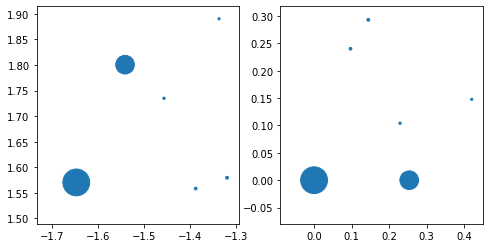

In [93]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
idx = 1
ax[0].scatter(orig.x[idx],
           orig.y[idx],
          s=ljparts_energy.flatten()[idx]*10)
ax[1].scatter(transformed.x[idx],
           transformed.y[idx],
          s=ljparts_energy.flatten()[idx]*10);

----

In [47]:
class JetImageProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        x_axis = hist.Bin('x', 'x', 9, -0.4, 0.4)
        y_axis = hist.Bin('y', 'y', 9, -0.4, 0.4)
        
        self._accumulator = processor.dict_accumulator({
            'im': hist.Hist("weights", dataset_axis, x_axis, y_axis),
            'um': hist.Hist("weights", dataset_axis, x_axis, y_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        ljpart_eta = NestNestObjArrayToJagged(df['pfjet_pfcand_eta'])[matchmask].flatten()
        ljpart_phi = NestNestObjArrayToJagged(df['pfjet_pfcand_phi'])[matchmask].flatten()
        ljpart_energy = NestNestObjArrayToJagged(df['pfjet_pfcand_energy'])[matchmask].flatten()
        
        transformed = transform(ljpart_eta, ljpart_phi, ljpart_energy)
        output['im'].fill(dataset=dataset,
                          x=transformed.x.flatten(),
                          y=transformed.y.flatten(),
                          weight=ljpart_energy.flatten())
        
        ljpart_eta = NestNestObjArrayToJagged(df['pfjet_pfcand_eta'])[~matchmask].flatten()
        ljpart_phi = NestNestObjArrayToJagged(df['pfjet_pfcand_phi'])[~matchmask].flatten()
        ljpart_energy = NestNestObjArrayToJagged(df['pfjet_pfcand_energy'])[~matchmask].flatten()
        
        transformed = transform(ljpart_eta, ljpart_phi, ljpart_energy)
        output['um'].fill(dataset=dataset,
                          x=transformed.x.flatten(),
                          y=transformed.y.flatten(),
                          weight=ljpart_energy.flatten())
        return output
    
    def postprocess(self, accumulator):
        return accumulator

### lxy: 0.3cm

In [52]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=JetImageProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:07<00:00,  2.85items/s]


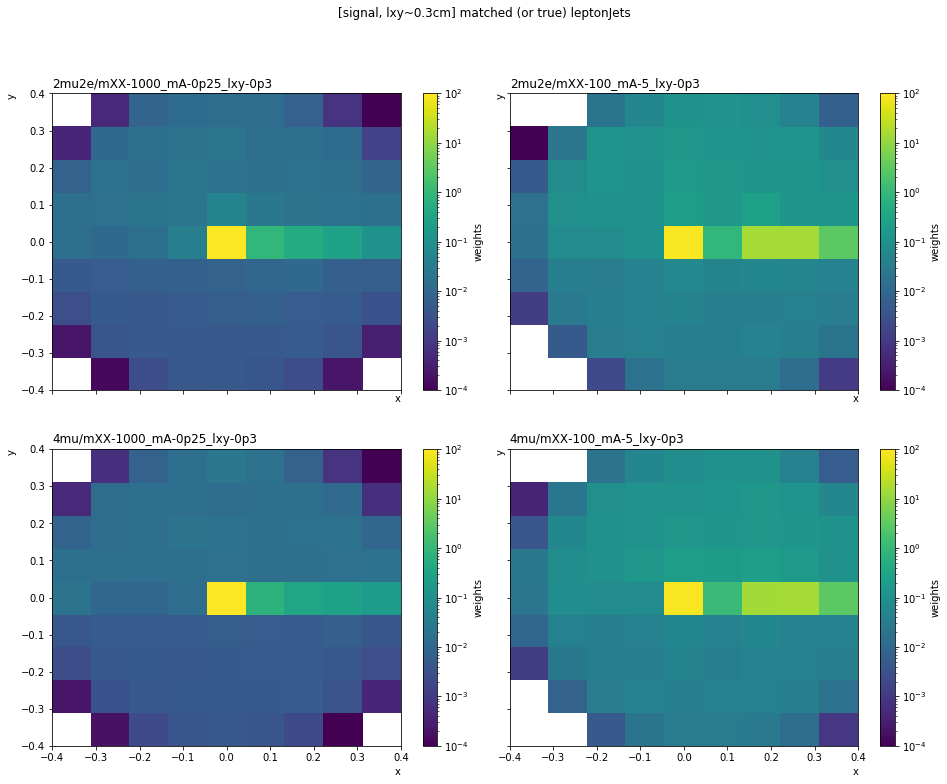

In [53]:
dsids = output['im'].identifiers('dataset')

fig, axes = plt.subplots(2,2,figsize=(16,12), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['im'].project('dataset', dsids[i]),
                xaxis='x', density=True, ax=ax,
                patch_opts=dict(norm=LogNorm(), vmin=1e-4, vmax=1e2))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal, lxy~0.3cm] matched (or true) leptonJets');

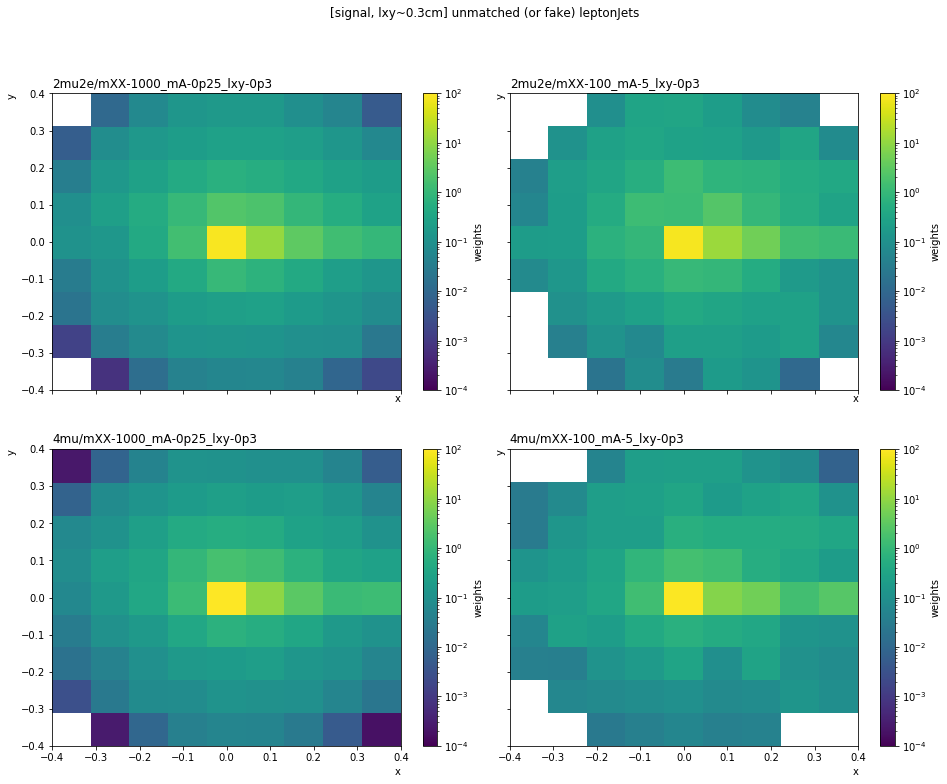

In [54]:
dsids = output['um'].identifiers('dataset')

fig, axes = plt.subplots(2,2,figsize=(16,12), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['um'].project('dataset', dsids[i]),
                xaxis='x', density=True, ax=ax,
                patch_opts=dict(norm=LogNorm(), vmin=1e-4, vmax=1e2))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal, lxy~0.3cm] unmatched (or fake) leptonJets');

### lxy: 300cm

In [48]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dict(files=dataset4mu_['mXX-100_mA-5_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '4mu/mXX-1000_mA-0p25_lxy-300': dict(files=dataset4mu_['mXX-1000_mA-0p25_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-100_mA-5_lxy-300': dict(files=dataset2mu2e_['mXX-100_mA-5_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dict(files=dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'], treename='ffNtuplizer/ffNtuple'),
}

output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=JetImageProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:10<00:00,  2.00items/s]


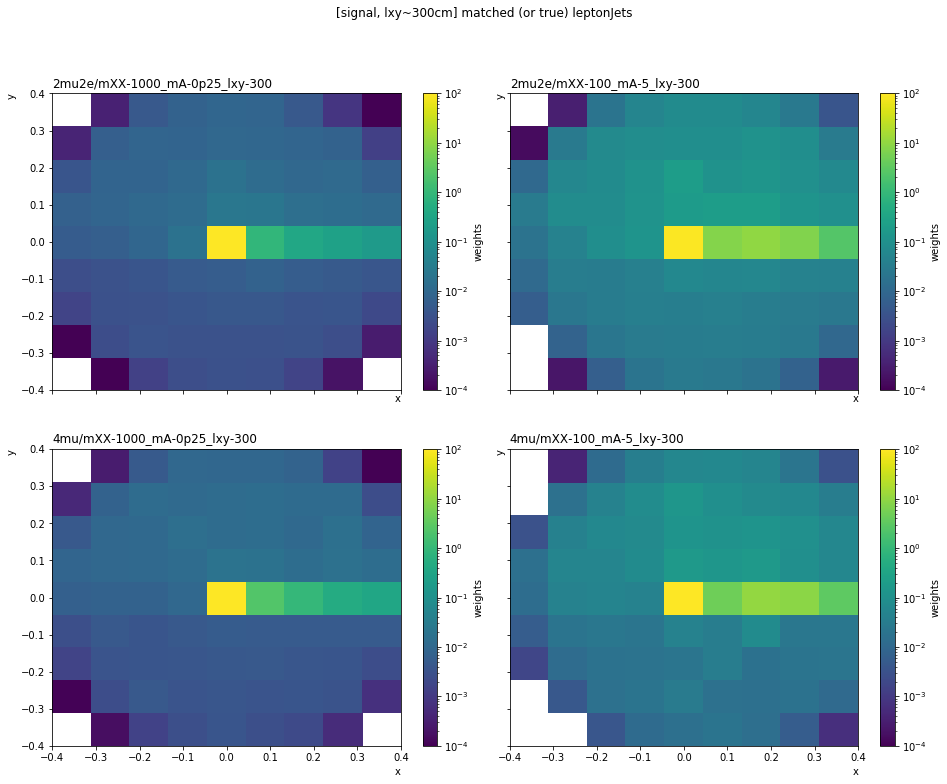

In [49]:
dsids = output['im'].identifiers('dataset')

fig, axes = plt.subplots(2,2,figsize=(16,12), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['im'].project('dataset', dsids[i]),
                xaxis='x', density=True, ax=ax,
                patch_opts=dict(norm=LogNorm(), vmin=1e-4, vmax=1e2))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal, lxy~300cm] matched (or true) leptonJets');

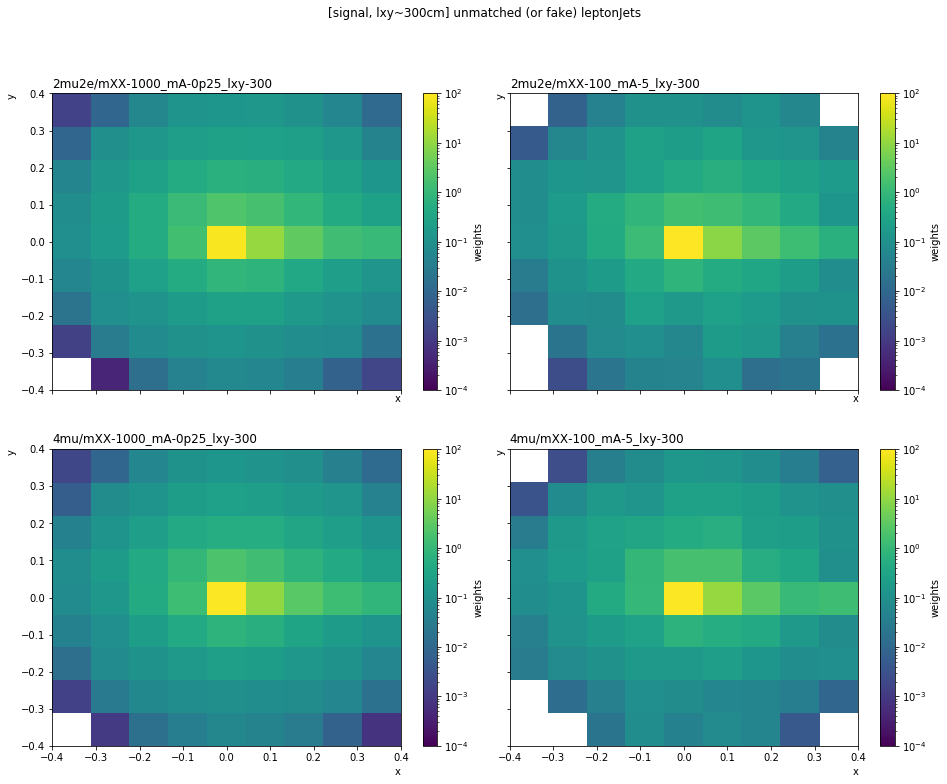

In [50]:
dsids = output['um'].identifiers('dataset')

fig, axes = plt.subplots(2,2,figsize=(16,12), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['um'].project('dataset', dsids[i]),
                xaxis='x', density=True, ax=ax,
                patch_opts=dict(norm=LogNorm(), vmin=1e-4, vmax=1e2))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
plt.suptitle('[signal, lxy~300cm] unmatched (or fake) leptonJets');

### background events: QCD, DYJets, TTJets

In [30]:
class JetImageProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        x_axis = hist.Bin('x', 'x', 9, -0.4, 0.4)
        y_axis = hist.Bin('y', 'y', 9, -0.4, 0.4)
        
        self._accumulator = processor.dict_accumulator({
            'im': hist.Hist("weights", dataset_axis, x_axis, y_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ljpart_eta = NestNestObjArrayToJagged(df['pfjet_pfcand_eta']).flatten()
        ljpart_phi = NestNestObjArrayToJagged(df['pfjet_pfcand_phi']).flatten()
        ljpart_energy = NestNestObjArrayToJagged(df['pfjet_pfcand_energy']).flatten()
        
        transformed = transform(ljpart_eta, ljpart_phi, ljpart_energy)
        output['im'].fill(dataset=dataset,
                          x=transformed.x.flatten(),
                          y=transformed.y.flatten(),
                          weight=ljpart_energy.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [29]:
for k in bkgdatasets_: print(k, list(bkgdatasets_[k].keys()))

TTJets ['TTJets', 'TTJets_SingleLeptFromT', 'TTJets_SingleLeptFromTbar', 'TTJets_DiLept']
ST ['AntiTop', 'Top']
WJets ['WJets_HT-70To100', 'WJets_HT-100To200', 'WJets_HT-200To400', 'WJets_HT-400To600', 'WJets_HT-600To800', 'WJets_HT-800To1200', 'WJets_HT-1200To2500', 'WJets_HT-2500ToInf']
DYJetsToLL ['DYJetsToLL-M-10to50', 'DYJetsToLL_M-50']
DiBoson ['WW', 'ZZ', 'WZ']
TriBoson ['WWW', 'WWZ', 'WZZ', 'ZZZ', 'WZG', 'WWG', 'WGG']
QCD ['QCD_Pt-20to30', 'QCD_Pt-50to80', 'QCD_Pt-80to120', 'QCD_Pt-120to170', 'QCD_Pt-170to300', 'QCD_Pt-300to470', 'QCD_Pt-470to600', 'QCD_Pt-600to800', 'QCD_Pt-800to1000', 'QCD_Pt-1000toInf']


In [31]:
dataset = {
    'TTJets_DiLept': bkgdatasets_['TTJets']['TTJets_DiLept'],
    'DYJets': bkgdatasets_['DYJetsToLL']['DYJetsToLL-M-10to50']+bkgdatasets_['DYJetsToLL']['DYJetsToLL_M-50']
}
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetImageProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 1529/1529 [04:46<00:00,  8.44items/s]


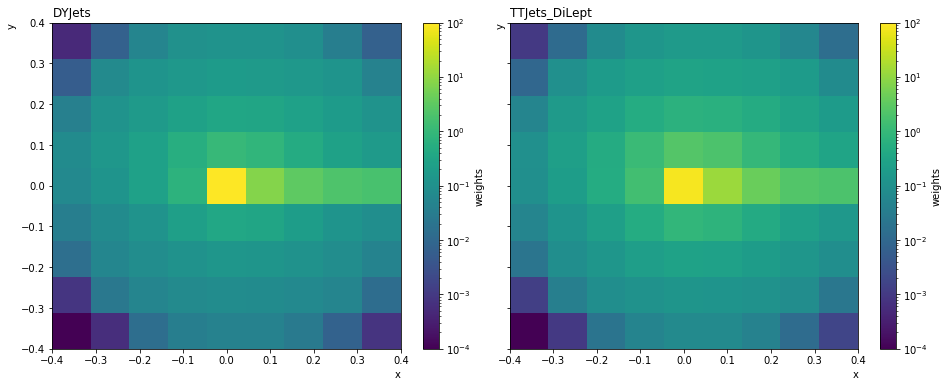

In [34]:
dsids = output['im'].identifiers('dataset')

fig, axes = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['im'].project('dataset', dsids[i]),
                xaxis='x', density=True, ax=ax,
                patch_opts=dict(norm=LogNorm(), vmin=1e-4, vmax=1e2))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
# plt.suptitle('[signal] unmatched (or fake) leptonJets');

In [35]:
dataset = bkgdatasets_['QCD']
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetImageProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 1256/1256 [04:14<00:00,  1.40items/s]


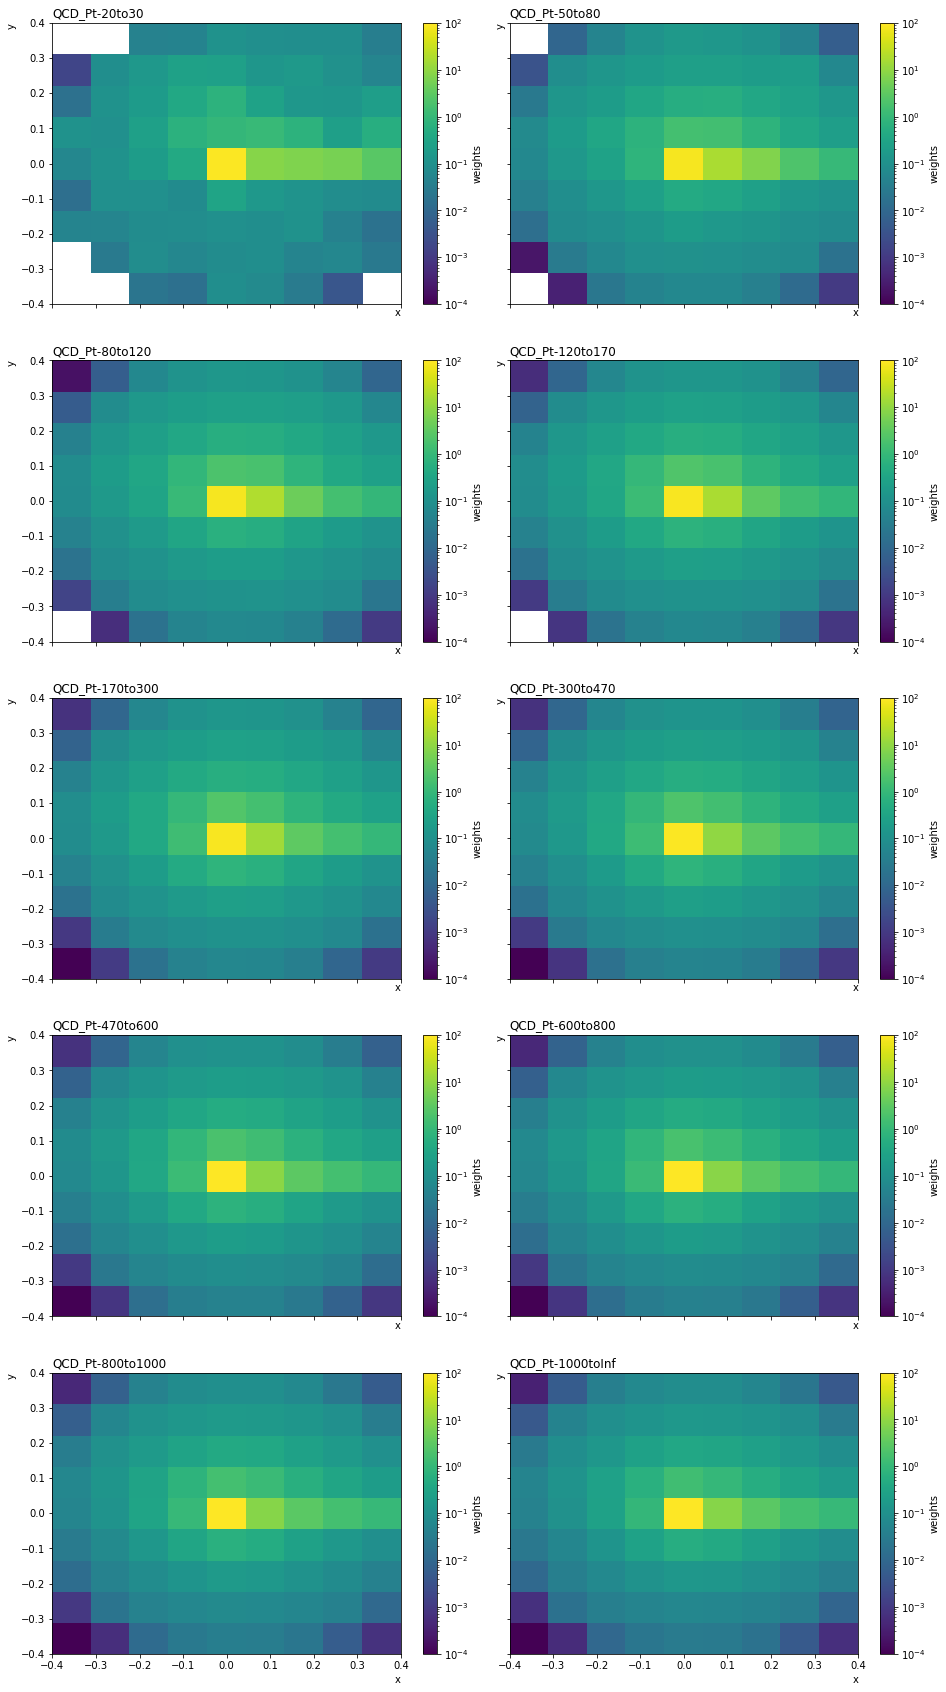

In [46]:
dsids = output['im'].identifiers('dataset')
dsids = sorted(dsids, key=lambda x: float(x.name.split('to')[-1]))

fig, axes = plt.subplots(5,2,figsize=(16,30), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    hist.plot2d(output['im'].project('dataset', dsids[i]),
                xaxis='x', density=True, ax=ax,
                patch_opts=dict(norm=LogNorm(), vmin=1e-4, vmax=1e2))
    ax.set_title(str(dsids[i]), x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

# separate image layers by pid (muon, electron, photon, dSAmuon)

In [3]:
class leptonJetDaughterTypeProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        type_axis = hist.Bin('pftype', 'PF Type', 9, 0, 9)
        self._accumulator = processor.dict_accumulator({
            'dau': hist.Hist('Counts', dataset_axis, type_axis)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ljdautype = NestNestObjArrayToJagged(df['pfjet_pfcand_type'])
        output['dau'].fill(dataset=dataset, pftype=ljdautype.flatten().flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [4]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dict(files=dataset4mu_['mXX-100_mA-5_lxy-0p3'], treename='ffNtuplizer/ffNtuple'),
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dict(files=dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-100_mA-5_lxy-0p3': dict(files=dataset2mu2e_['mXX-100_mA-5_lxy-0p3'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dict(files=dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'], treename='ffNtuplizer/ffNtuple'),
}

output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=leptonJetDaughterTypeProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  6.65items/s]


In [9]:
dsids = output['dau'].identifiers('dataset')
for i in dsids:
    print(i)
    print(output['dau'].project('dataset', i).values()[()])

2mu2e/mXX-1000_mA-0p25_lxy-0p3
[    0.     0.    84.  9826. 53501.     0.     0.     0.   554.]
2mu2e/mXX-100_mA-5_lxy-0p3
[    0.     0.  4060.  5434. 22325.     0.     0.     0.    24.]
4mu/mXX-1000_mA-0p25_lxy-0p3
[0.0000e+00 0.0000e+00 2.8000e+01 1.9388e+04 7.0292e+04 0.0000e+00
 0.0000e+00 0.0000e+00 1.3280e+03]
4mu/mXX-100_mA-5_lxy-0p3
[0.0000e+00 0.0000e+00 6.0000e+00 1.0739e+04 2.4538e+04 0.0000e+00
 0.0000e+00 0.0000e+00 6.1000e+01]


- lxy: 300cm

In [10]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dict(files=dataset4mu_['mXX-100_mA-5_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '4mu/mXX-1000_mA-0p25_lxy-300': dict(files=dataset4mu_['mXX-1000_mA-0p25_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-100_mA-5_lxy-300': dict(files=dataset2mu2e_['mXX-100_mA-5_lxy-300'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dict(files=dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'], treename='ffNtuplizer/ffNtuple'),
}

output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=leptonJetDaughterTypeProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.99items/s]


In [11]:
dsids = output['dau'].identifiers('dataset')
for i in dsids:
    print(i)
    print(output['dau'].project('dataset', i).values()[()])

2mu2e/mXX-1000_mA-0p25_lxy-300
[0.00000e+00 0.00000e+00 1.72000e+02 4.68800e+03 1.72834e+05 0.00000e+00
 0.00000e+00 0.00000e+00 3.08200e+03]
2mu2e/mXX-100_mA-5_lxy-300
[    0.     0.   292.  3582. 35224.     0.     0.     0.  1714.]
4mu/mXX-1000_mA-0p25_lxy-300
[0.00000e+00 0.00000e+00 1.04000e+02 8.16300e+03 1.28974e+05 0.00000e+00
 0.00000e+00 0.00000e+00 7.12900e+03]
4mu/mXX-100_mA-5_lxy-300
[0.0000e+00 0.0000e+00 8.0000e+00 6.5040e+03 2.2873e+04 0.0000e+00
 0.0000e+00 0.0000e+00 3.5020e+03]


<hr>
So we only observe type in {2,3,4,8}, which corresponding to e, $\mu$, $\gamma$, and dSA$\mu$.
<hr>

In [12]:
class JetImageLayerProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        x_axis = hist.Bin('x', 'x', 9, -0.4, 0.4)
        y_axis = hist.Bin('y', 'y', 9, -0.4, 0.4)
        t_axis = hist.Bin('t', 'type', 9, 0, 9)
        
        self._accumulator = processor.dict_accumulator({
            'im': hist.Hist("weights", dataset_axis, x_axis, y_axis, t_axis),
            'um': hist.Hist("weights", dataset_axis, x_axis, y_axis, t_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        ljpart_eta = NestNestObjArrayToJagged(df['pfjet_pfcand_eta'])[matchmask].flatten()
        ljpart_phi = NestNestObjArrayToJagged(df['pfjet_pfcand_phi'])[matchmask].flatten()
        ljpart_energy = NestNestObjArrayToJagged(df['pfjet_pfcand_energy'])[matchmask].flatten()
        ljpart_type = NestNestObjArrayToJagged(df['pfjet_pfcand_type'])[matchmask].flatten()
        
        transformed = transform(ljpart_eta, ljpart_phi, ljpart_energy)
        output['im'].fill(dataset=dataset,
                          x=transformed.x.flatten(),
                          y=transformed.y.flatten(),
                          t=ljpart_type.flatten(),
                          weight=ljpart_energy.flatten())
        
        ljpart_eta = NestNestObjArrayToJagged(df['pfjet_pfcand_eta'])[~matchmask].flatten()
        ljpart_phi = NestNestObjArrayToJagged(df['pfjet_pfcand_phi'])[~matchmask].flatten()
        ljpart_energy = NestNestObjArrayToJagged(df['pfjet_pfcand_energy'])[~matchmask].flatten()
        ljpart_type = NestNestObjArrayToJagged(df['pfjet_pfcand_type'])[~matchmask].flatten()
        
        transformed = transform(ljpart_eta, ljpart_phi, ljpart_energy)
        output['um'].fill(dataset=dataset,
                          x=transformed.x.flatten(),
                          y=transformed.y.flatten(),
                          t=ljpart_type.flatten(),
                          weight=ljpart_energy.flatten())
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [31]:
def makeLayerPlot(histos, suptitle, sortby=None):
    """
    dataset per row, category per column.
    From left -> right: 2, 3, 4, 8
    """
    
    dsids = histos.identifiers('dataset')
    if sortby:
        dsids = sorted(dsids, key=sortby)

    fig, axes = plt.subplots(len(dsids),4,
                             figsize=(20,4*len(dsids)),
                             gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)

    pfids = [(2, 'e'), (3, '$\mu$'), (4, '$\gamma$'), (8, 'dSA$\mu$')]
    for i, ds in enumerate(dsids):
        for j, (pfid, name) in enumerate(pfids):
            hist.plot2d(histos.project('dataset', ds).project('t', pfid),
                        xaxis='x', density=True, ax=axes[i][j],
                        patch_opts=dict(norm=LogNorm(), vmin=1e-3, vmax=1e2))
            axes[i][j].set_title(str(ds)+' '+name, x=0.0, ha="left")

    for ax in axes.flat:
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    plt.suptitle(suptitle);

- lxy: 0.3cm

In [15]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetImageLayerProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:09<00:00,  1.24items/s]


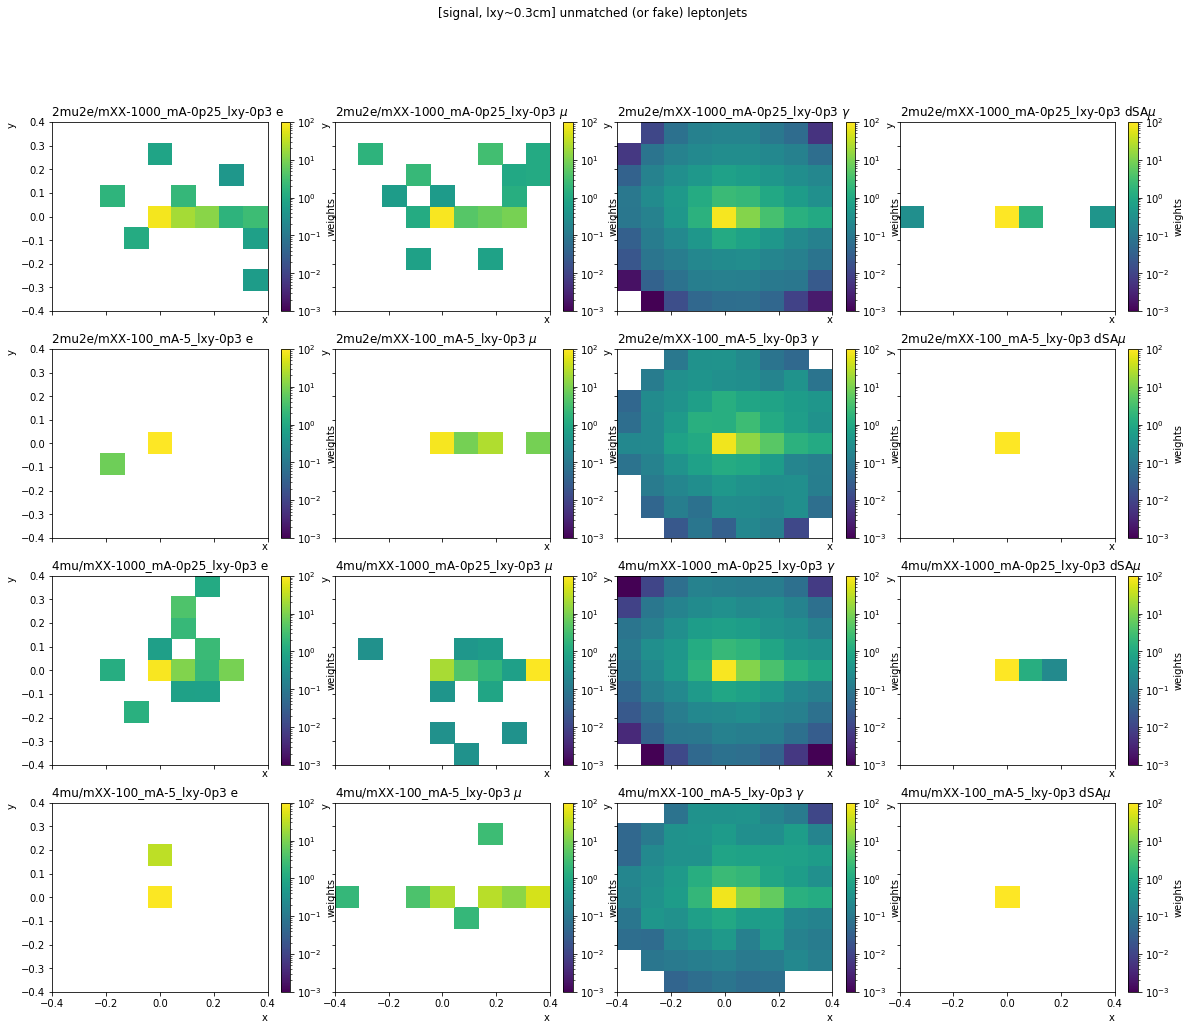

In [21]:
suptitle = '[signal, lxy~0.3cm] unmatched (or fake) leptonJets'
makeLayerPlot(output['um'], suptitle);

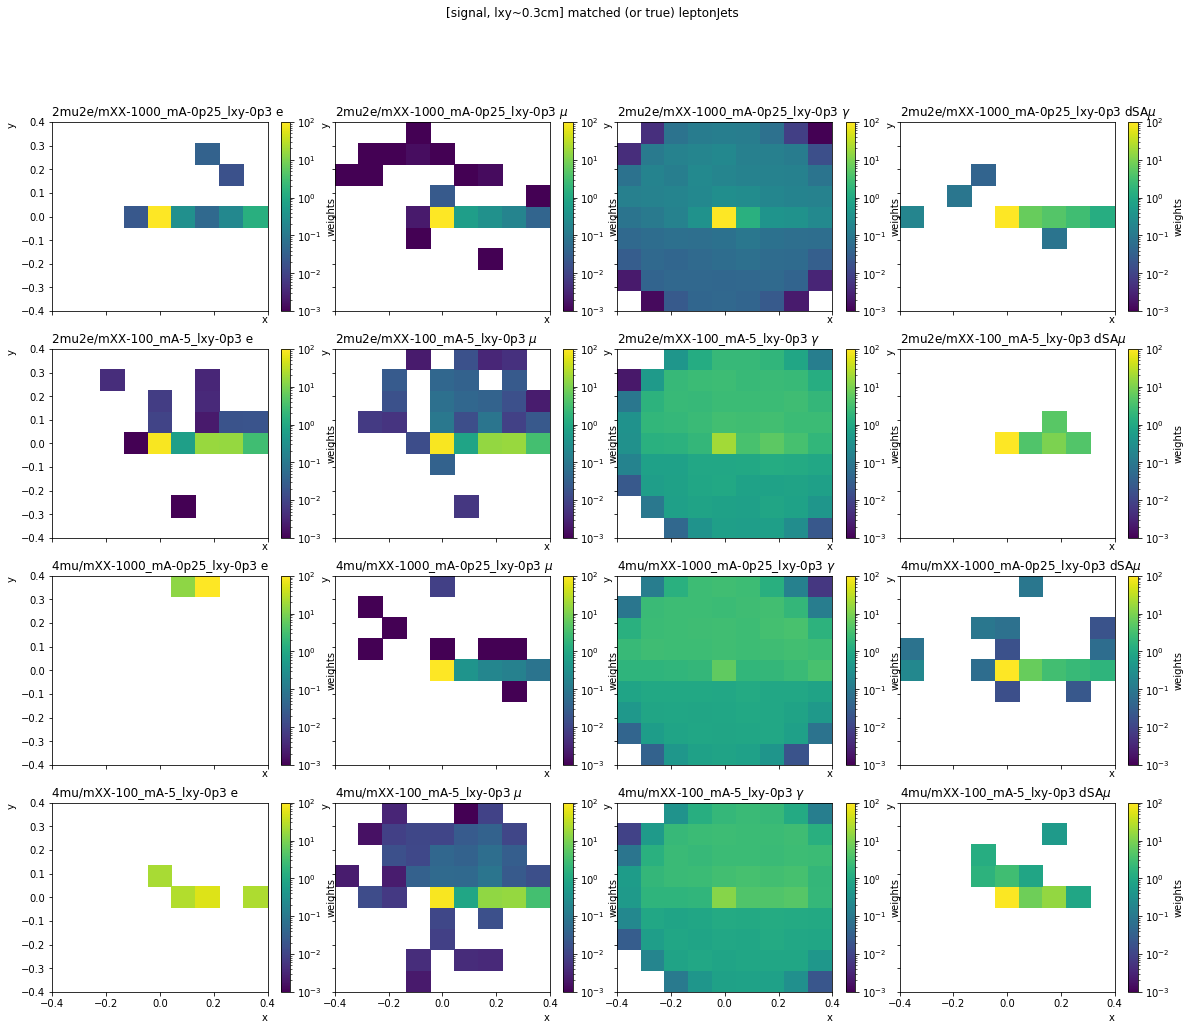

In [22]:
suptitle = '[signal, lxy~0.3cm] matched (or true) leptonJets'
makeLayerPlot(output['im'], suptitle);

- lxy: 300cm

In [23]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300': dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetImageLayerProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:11<00:00,  1.42s/items]


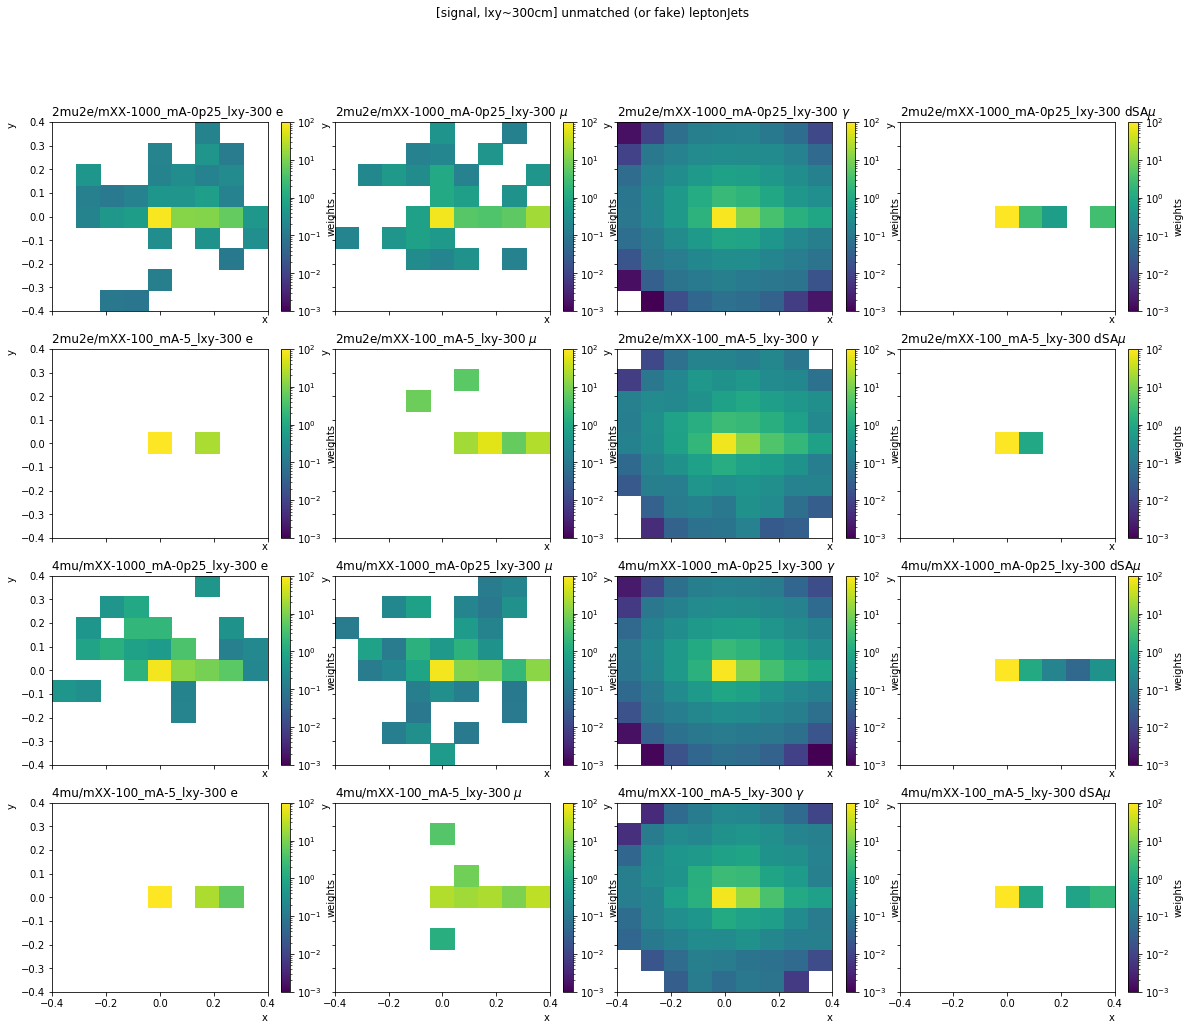

In [24]:
suptitle = '[signal, lxy~300cm] unmatched (or fake) leptonJets'
makeLayerPlot(output['um'], suptitle);

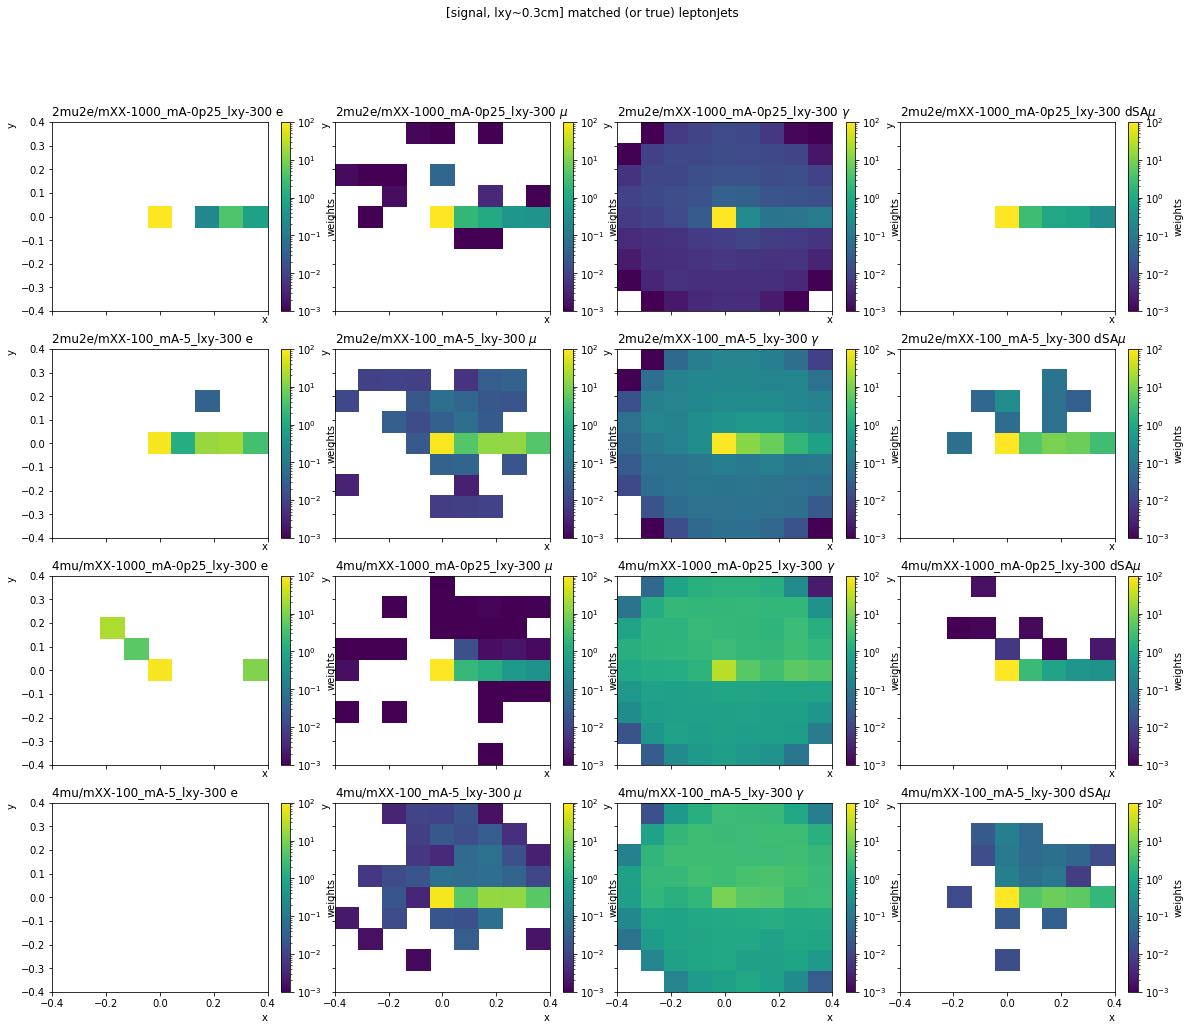

In [25]:
suptitle = '[signal, lxy~0.3cm] matched (or true) leptonJets'
makeLayerPlot(output['im'], suptitle);

### background events: QCD, DYJets, TTJets

In [27]:
class JetImageLayerProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        x_axis = hist.Bin('x', 'x', 9, -0.4, 0.4)
        y_axis = hist.Bin('y', 'y', 9, -0.4, 0.4)
        t_axis = hist.Bin('t', 'type', 9, 0, 9)
        
        self._accumulator = processor.dict_accumulator({
            'im': hist.Hist("weights", dataset_axis, x_axis, y_axis, t_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ljpart_eta = NestNestObjArrayToJagged(df['pfjet_pfcand_eta']).flatten()
        ljpart_phi = NestNestObjArrayToJagged(df['pfjet_pfcand_phi']).flatten()
        ljpart_energy = NestNestObjArrayToJagged(df['pfjet_pfcand_energy']).flatten()
        ljpart_type = NestNestObjArrayToJagged(df['pfjet_pfcand_type']).flatten()
        
        transformed = transform(ljpart_eta, ljpart_phi, ljpart_energy)
        output['im'].fill(dataset=dataset,
                          x=transformed.x.flatten(),
                          y=transformed.y.flatten(),
                          t=ljpart_type.flatten(),
                          weight=ljpart_energy.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [28]:
dataset = {
    'TTJets_DiLept': bkgdatasets_['TTJets']['TTJets_DiLept'],
    'DYJets': bkgdatasets_['DYJetsToLL']['DYJetsToLL-M-10to50']+bkgdatasets_['DYJetsToLL']['DYJetsToLL_M-50']
}
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetImageLayerProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 1529/1529 [04:03<00:00,  6.28items/s]


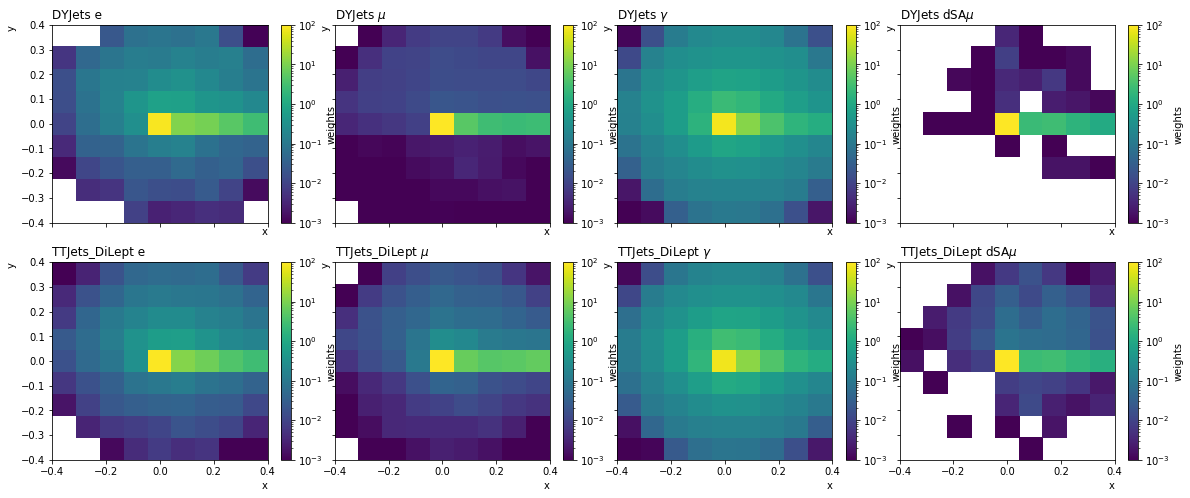

In [29]:
makeLayerPlot(output['im'], '')

In [30]:
dataset = bkgdatasets_['QCD']
output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=JetImageLayerProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 1256/1256 [04:04<00:00,  1.26items/s]


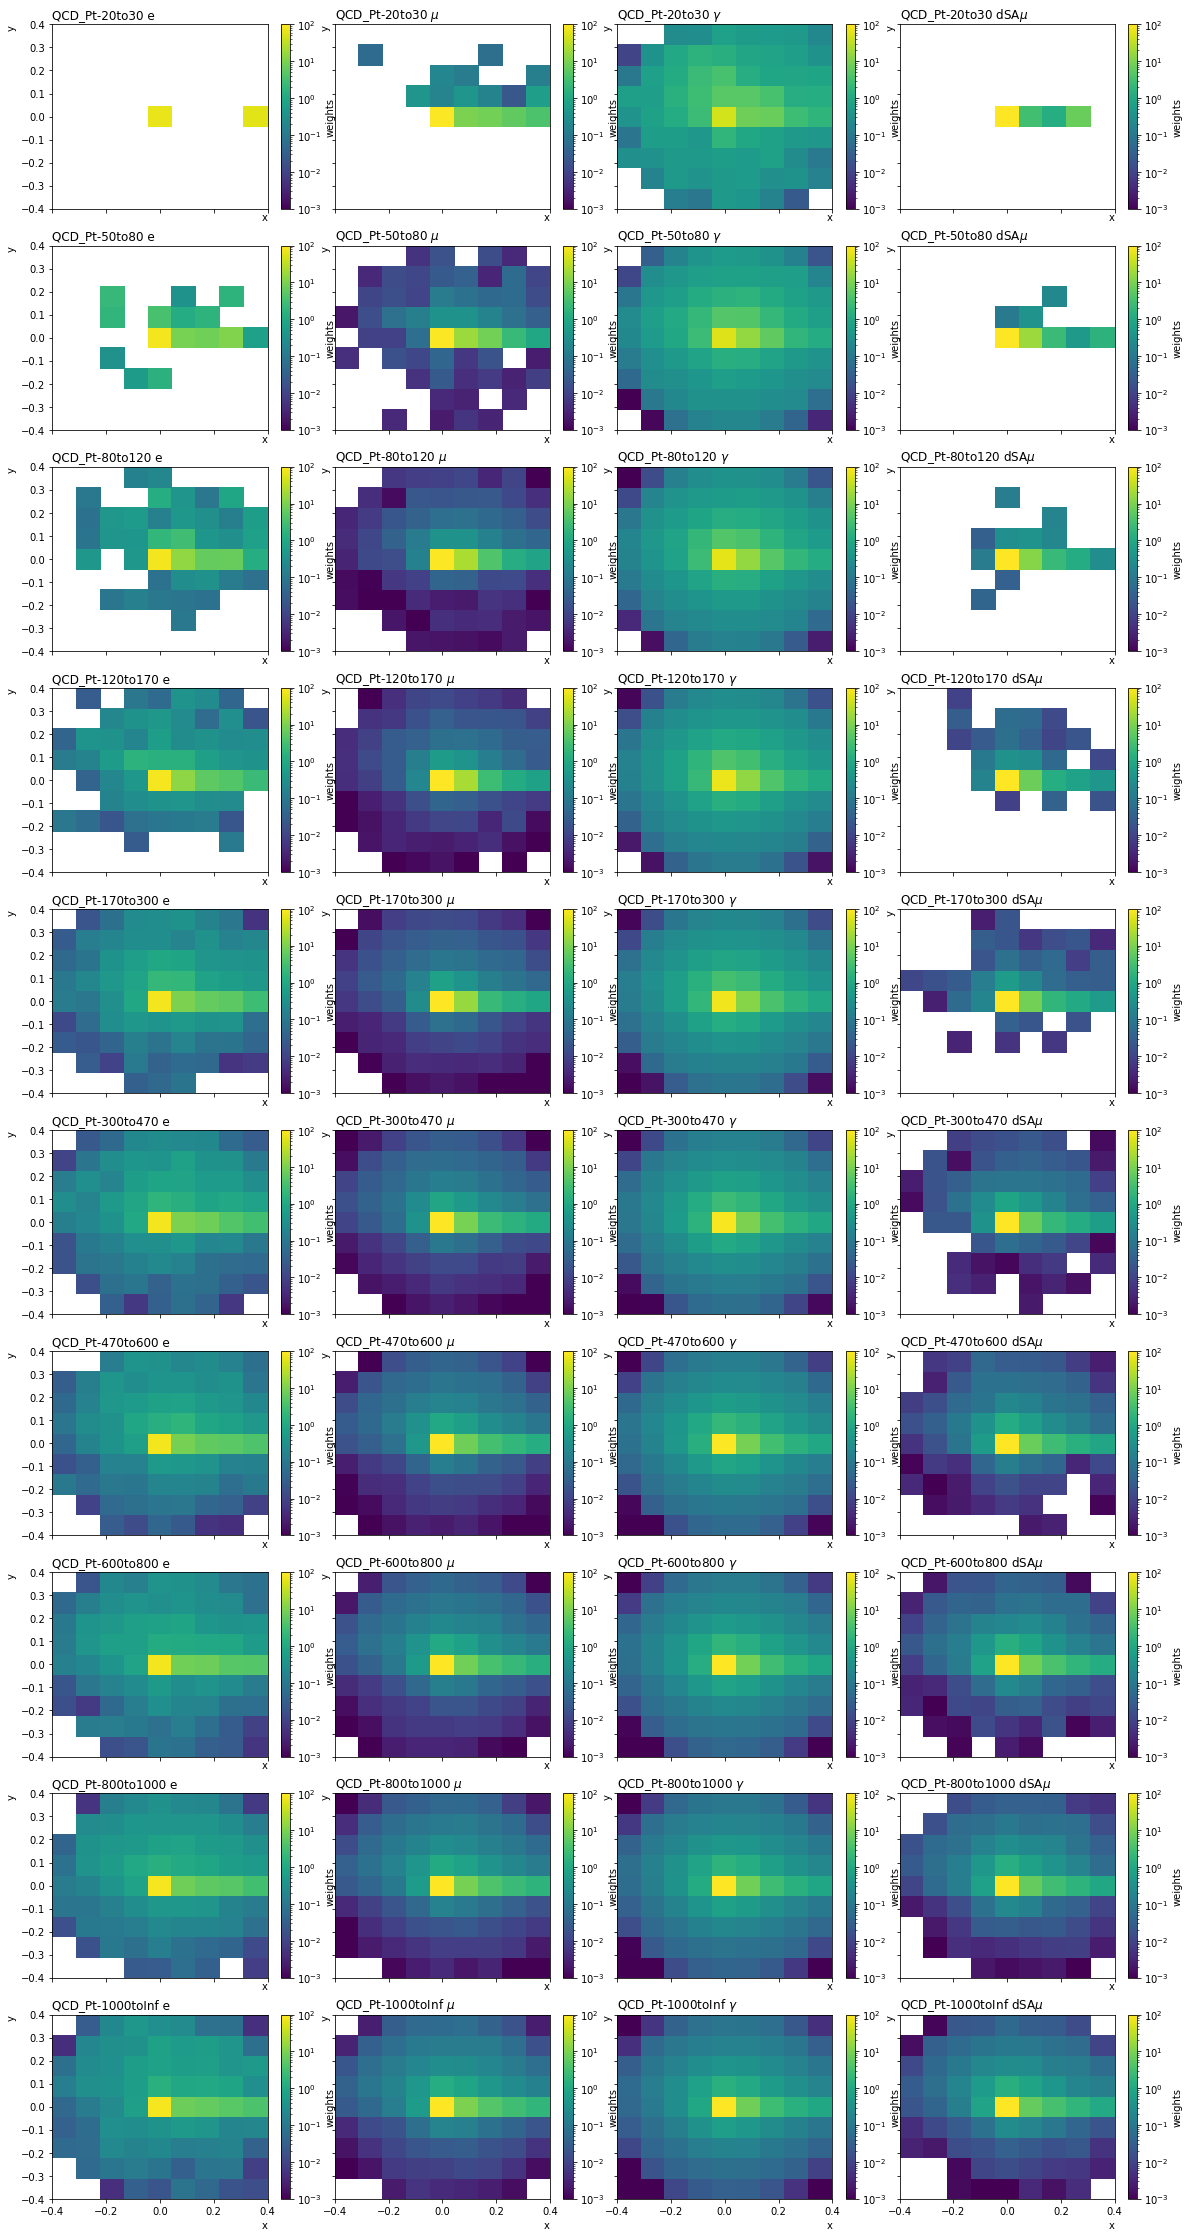

In [32]:
makeLayerPlot(output['im'], None, sortby=lambda x: float(x.name.split('to')[-1]))